In [1]:
import pandas as pd
import numpy as np
import swifter
import json
import math
import time
import ast
import re

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import DBSCAN

In [4]:
with open("backup/dictionary.json") as file:
    dictionary =      {int(k):v for k,v in json.load(file).items()}
with open("backup/dictionary_rev.json") as file:
    dictionary_rev =  {k:int(v) for k,v in json.load(file).items()}
with open("backup/docs_containing.json") as file:
    docs_containing = {int(k):v for k,v in json.load(file).items()}
with open("backup/dict_idf.json") as file:
    dict_idf =        {int(k):v for k,v in json.load(file).items()}

In [2]:
df = pd.read_csv("backup/tfidf.csv", index_col=0).drop(columns="File")
df.iloc[:, 1:] = df.iloc[:,1:].swifter.applymap(ast.literal_eval)

In [5]:
df["Top10"] = df["TFIDF"].apply(lambda x:
    dict(sorted(x.items(), key=lambda i:i[1])[::-1][:10])
)

top10_collection = []
for idx in df.index:
    top10_collection.extend(df.loc[idx, "Top10"])
top10_collection = sorted(set(top10_collection))

print("Top 10 collection contains", len(top10_collection), "unique tokens..",
      round(len(top10_collection)/len(dictionary)*100, 2), "% of total dictionary")

Top 10 collection contains 7146 unique tokens.. 10.99 % of total dictionary


In [6]:
collections = {"Top10" : top10_collection}
def set_vector(top_x: str="Top10") -> None:
    df["Vector"] = df[top_x].swifter.apply(lambda x: 
        list(map(lambda idx: x[idx] if idx in x else 0, collections[top_x])))
    
set_vector("Top10")
matrix = np.array(list(map(np.array, df["Vector"])))

In [7]:
non_zero_idxs_matrix = np.array([
    np.nonzero(arr)[0]
    for arr in matrix
])

def sparse_vector_distance(idx_a, idx_b):
    idx_concat = np.concatenate((
        non_zero_idxs_matrix[idx_a],
        non_zero_idxs_matrix[idx_b]))
    
    return math.sqrt(sum(map(
        lambda x: (x[1]-x[0])**2, 
        zip(matrix[idx_a][idx_concat],
            matrix[idx_b][idx_concat])
    )))

In [8]:
start = time.time()
cross_distance_matrix = np.array([
    sparse_vector_distance(i, ii)
    for i in range(len(matrix))
    for ii in range(len(matrix))
]).reshape(len(matrix),len(matrix))
print("Took", round(time.time() -start, 2), "seconds.")

Took 75.7 seconds.


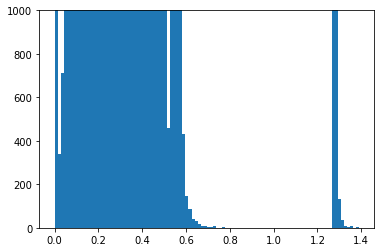

In [215]:
plt.hist(cross_distance_matrix.flatten(), bins=100)
plt.ylim(0,1000)
plt.show()

In [218]:
dbscan = DBSCAN(eps=.8).fit_predict(matrix)
dict(zip(*np.unique(dbscan, return_counts=True)))

{-1: 1, 0: 1727}

In [228]:
argmax = cross_distance_matrix.reshape(len(matrix),len(matrix)).argmax()
cross_distance_matrix[argmax // len(matrix), argmax % len(matrix)]

1.389044460289989

In [246]:
min_distances = [
    np.min(cross_distance_matrix[i][np.nonzero(cross_distance_matrix[i])])
    for i in range(len(cross_distance_matrix))
]
median_distances = [
    np.median(cross_distance_matrix[i][np.nonzero(cross_distance_matrix[i])])
    for i in range(len(cross_distance_matrix))
]

In [252]:
unique, counts = np.unique(
    list(map(
        lambda x: round(x, 2), 
        min_distances
)), return_counts=True)

sorted(
    zip(unique, counts),
    key=lambda x:x[1]
)[::-1][:10]

[(0.03, 247),
 (0.04, 218),
 (0.02, 176),
 (0.05, 142),
 (0.06, 128),
 (0.07, 107),
 (0.08, 95),
 (0.1, 67),
 (0.11, 65),
 (0.12, 61)]

In [251]:
unique, counts = np.unique(
    list(map(
        lambda x: round(x, 2), 
        median_distances
)), return_counts=True)

sorted(
    zip(unique, counts),
    key=lambda x:x[1]
)[::-1][:10]

[(0.16, 225),
 (0.17, 213),
 (0.14, 213),
 (0.15, 206),
 (0.13, 166),
 (0.18, 143),
 (0.19, 131),
 (0.2, 99),
 (0.21, 82),
 (0.22, 55)]

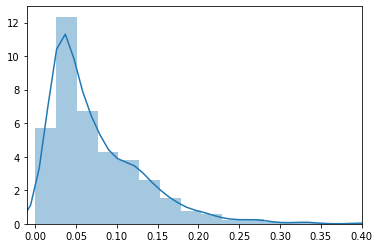

In [297]:
sn.distplot(min_distances)
plt.xlim(-.01, .4)
plt.show()

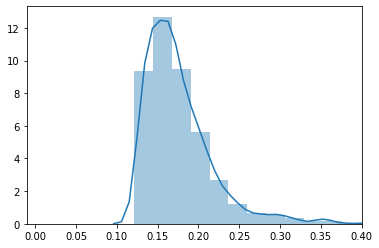

In [298]:
sn.distplot(median_distances)
plt.xlim(-.01, .4)
plt.show()

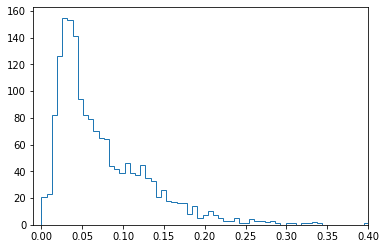

In [285]:
    plt.hist(
        min_distances,
        bins=200,
        histtype=u'step'
    )
    plt.xlim(-.01, .4)
    plt.show()

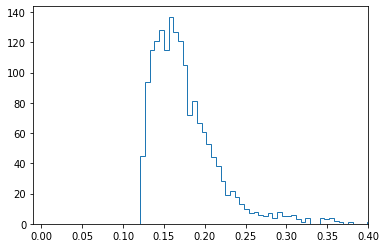

In [286]:
plt.hist(
    median_distances,
    bins=200,
    histtype=u'step'
)
plt.xlim(-.01, .4)
plt.show()

In [282]:
dbscan = DBSCAN(eps=0.17).fit_predict(matrix)

In [283]:
dict(zip(*np.unique(dbscan, return_counts=True)))

{-1: 193, 0: 1520, 1: 5, 2: 5, 3: 5}